<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Защита-персональных-данных-клиентов" data-toc-modified-id="Защита-персональных-данных-клиентов-1">Защита персональных данных клиентов</a></span><ul class="toc-item"><li><span><a href="#Загрузка-данных" data-toc-modified-id="Загрузка-данных-1.1">Загрузка данных</a></span><ul class="toc-item"><li><span><a href="#Переименование-столбцов" data-toc-modified-id="Переименование-столбцов-1.1.1">Переименование столбцов</a></span></li><li><span><a href="#Удаление-дубликатов" data-toc-modified-id="Удаление-дубликатов-1.1.2">Удаление дубликатов</a></span></li><li><span><a href="#Анализ-признаков" data-toc-modified-id="Анализ-признаков-1.1.3">Анализ признаков</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-1.1.4">Вывод</a></span></li></ul></li><li><span><a href="#Умножение-матриц" data-toc-modified-id="Умножение-матриц-1.2">Умножение матриц</a></span></li><li><span><a href="#Алгоритм-преобразования" data-toc-modified-id="Алгоритм-преобразования-1.3">Алгоритм преобразования</a></span></li><li><span><a href="#Проверка-алгоритма" data-toc-modified-id="Проверка-алгоритма-1.4">Проверка алгоритма</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-1.5">Вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-1.6">Чек-лист проверки</a></span></li></ul></li></ul></div>

# Защита персональных данных клиентов

Необходимо защитить данные клиентов страховой компании. Требуется разработать такой метод преобразования данных, чтобы по ним было сложно восстановить персональную информацию, и обосновать корректность его работы.

Нужно защитить данные так, чтобы при преобразовании качество моделей машинного обучения не ухудшилось. 

## Загрузка данных

Импорт библиотек, которые потребуются для выполнения исследования:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score 
import warnings
warnings.filterwarnings('ignore')

Загрузка датасета:

In [2]:
insurance = pd.read_csv('/datasets/insurance.csv')

Получение данных о первых пяти строках таблицы **insurance**:

In [3]:
insurance.head()

,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
0,1,41.0,49600.0,1,0
1,0,46.0,38000.0,1,1
2,0,29.0,21000.0,0,0
3,0,21.0,41700.0,2,0
4,1,28.0,26100.0,0,0


Общая информация о данных таблицы **insurance**:

In [4]:
insurance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
Пол                  5000 non-null int64
Возраст              5000 non-null float64
Зарплата             5000 non-null float64
Члены семьи          5000 non-null int64
Страховые выплаты    5000 non-null int64
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


В датафрейме **insurance** представлена информация о характеристиках клиентов страховой компании: 

- **Пол** — пол клиента;
- **Возраст** — возраст;
- **Зарплата** — размер зарплаты;
- **Члены семьи** — количество человек в семьег;
- **Страховые выплаты** — количество страховых выплат клиенту за последние 5 лет.

Общее количество объектов - 5 000. Пропусков нет. Все данные числового вида (целочисленныого или вещественного типа). 

---

Подготовим исходные данные для дальнейшего исседования и построения прогноза.

### Переименование столбцов

Переименуем столбцы в соответствии с общепринятой практикой:

In [5]:
insurance.columns = ['gender', 'age', 'salary', 'n_family_members', 'payments']

### Удаление дубликатов

In [6]:
insurance.duplicated().sum()

153

В данных встречаются полностью одинаковые строки, однако удалять их бессмысленно, поскольку нет ни одного столбца с уникальным идентификатором клиента. В таблицу могли попасть клиенты, по случайности обладающие одинаковым набором характеристик.

### Анализ признаков

Теперь рассмотрим отдельно каждый столбец на предмет наличия ошибок в данных, аномалий и пр. Начнем с целевой переменной - количества страховых выплат клиенту за последние 5 лет.

**payments - количество страховых выплат клиенту за последние 5 лет**

In [7]:
display(insurance['payments'].value_counts())
display(insurance['payments'].value_counts(normalize = True))

0    4436
1     423
2     115
3      18
4       7
5       1
Name: payments, dtype: int64

0    0.8872
1    0.0846
2    0.0230
3    0.0036
4    0.0014
5    0.0002
Name: payments, dtype: float64

Выплаты получило 11,3% клиентов, причем более одной - всего 2,8%

In [8]:
#вспомогательная функция для отображения процентов на графике
#принимает на вход название графика, сдвиг надписи по горизонтали и по вертикали

def show_percent(figure, shift, height):
    totals = []
    for i in figure.patches:
        totals.append(i.get_height())
    
    total = sum(totals)

    for i in figure.patches:
        figure.text(i.get_x() + shift, i.get_height() + height, \
            str(round((i.get_height() / total) * 100, 2)) + '%', fontsize=12,
                color = 'black')

In [9]:
pay = insurance.groupby(by = 'payments').agg({'salary' : 'count'}).reset_index()\
                         .rename(columns = {'salary':'n'}).sort_values(by = 'n', ascending = False)

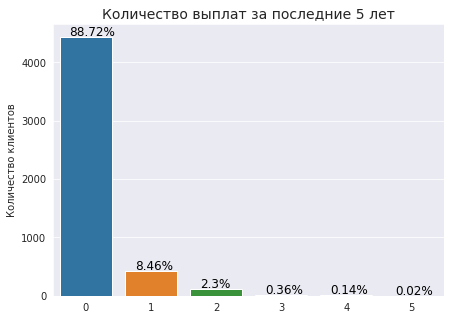

In [10]:
plt.figure(figsize=(7, 5))
sns.set_style("darkgrid")
fig = sns.barplot(x = "payments", y = "n", data = pay);
fig.set_title("Количество выплат за последние 5 лет", fontsize = 14)
fig.set_ylabel("Количество клиентов", fontsize = 10)
fig.set_xlabel("")
show_percent(fig, 0.15, 20)

**gender — пол**

In [11]:
insurance['gender'].value_counts(normalize = True)

0    0.501
1    0.499
Name: gender, dtype: float64

В выборке практически поровну мужчин и женщин. В условии нет уточнения, как (0 или 1) закодированы мужчины, а как - женщины.

Для наглядности разделим датасет на две выборки. В первую включим клиентов, по которым не было совершено ни одной выплаты, во вторую - всех остальных (для рассмотрения в первом приближении дробить клиентов на большее число групп нет смысла - количество клиентов с двумя и более выплатами крайне мало).

In [12]:
pay_no = insurance.loc[insurance['payments'] == 0]
pay_yes = insurance.loc[insurance['payments'] > 0]

In [13]:
gend_py = pay_yes.groupby(by = 'gender').agg({'salary' : 'count'}).reset_index()\
                         .rename(columns = {'salary':'n'})
gend_pn = pay_no.groupby(by = 'gender').agg({'salary' : 'count'}).reset_index()\
                         .rename(columns = {'salary':'n'})

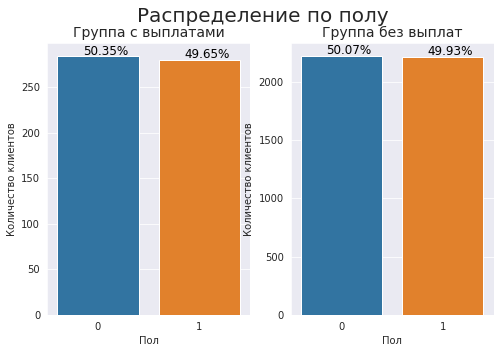

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(8, 5))

fig.suptitle('Распределение по полу', fontsize = 20)

fig1 = sns.barplot(ax = axes[0], x = "gender", y = "n", data = gend_py) 
fig1.set_title("Группа с выплатами", fontsize = 14)
fig1.set_ylabel("Количество клиентов", fontsize = 10)
fig1.set_xlabel("Пол")
show_percent(fig1, 0.25, 1.5)

fig2 = sns.barplot(ax = axes[1], x = "gender", y = "n", data = gend_pn) 
fig2.set_title("Группа без выплат", fontsize = 14)
fig2.set_ylabel("Количество клиентов", fontsize = 10)
fig2.set_xlabel("Пол")
show_percent(fig2, 0.25, 20)

plt.show()

Существенной разницы между группами по распределению пола нет. 

**age — возраст**

In [15]:
insurance['age'].describe()

count    5000.000000
mean       30.952800
std         8.440807
min        18.000000
25%        24.000000
50%        30.000000
75%        37.000000
max        65.000000
Name: age, dtype: float64

Самому молодому клиенту 18 лет, а самому возрастному - 65. Средний возраст составляет около 31 года (медиана - 30 лет), стандартное отклонение - 8,44 года.

Построим график распределения:

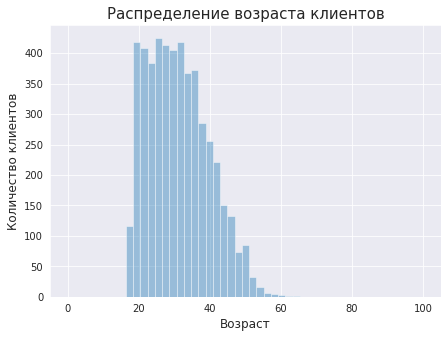

In [16]:
plt.figure(figsize=(7, 5))
fig = sns.distplot(insurance['age'], kde = False, bins = np.linspace(start = 0, stop = 100, num = 50))
fig.set_title("Распределение возраста клиентов", fontsize = 15)
fig.set_xlabel("Возраст", fontsize = 12)
fig.set_ylabel("Количество клиентов", fontsize = 12)

plt.show()

Распределение существенно отличается от нормального. Основная часть клиентов - молодые люди от 20 до 40 лет.

Среднее значение признака **age** на 17,6 лет выше в группе, где клиенты получали страховые выплаты:

In [17]:
pay_yes['age'].mean().round(3)

46.543

In [18]:
pay_no['age'].mean().round(3)

28.971

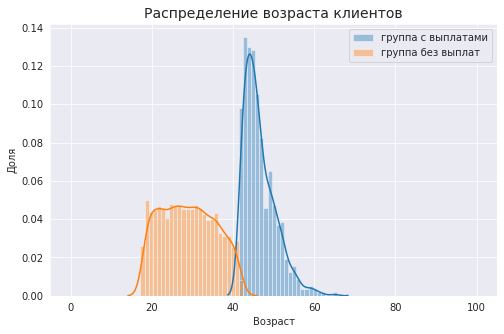

In [19]:
plt.figure(figsize=(8, 5))
fig1 = sns.distplot(pay_yes['age'], kde = True, \
                    bins = np.linspace(start = 0, stop = 100, num = 100), label = 'группа с выплатами') 
fig2 = sns.distplot(pay_no['age'], kde = True, \
                    bins = np.linspace(start = 0, stop = 100, num = 100), label = 'группа без выплат')  
fig2.set_title("Распределение возраста клиентов", fontsize = 14)
fig2.set_ylabel("Доля", fontsize = 10)
fig2.set_xlabel("Возраст")
plt.legend()
plt.show()

Группы по возрасту практически не пересекаются. Страховые возмещения получали преимущественно люди от 43 до 62 лет. И совсем незначительная доля клиентов старше 40 лет не получала выплат в принципе.

**salary — размер зарплаты**

In [20]:
insurance['salary'].describe()

count     5000.000000
mean     39916.360000
std       9900.083569
min       5300.000000
25%      33300.000000
50%      40200.000000
75%      46600.000000
max      79000.000000
Name: salary, dtype: float64

Минимальное значение зарплаты - 5 300 у.е., максимальное - 79 000. Средняя зарплата оставляет 39 916 у.е и практически совпадает с медианной - 40 200 у.е. Все значения выглядят правдоподобно.

Построим график распределения:

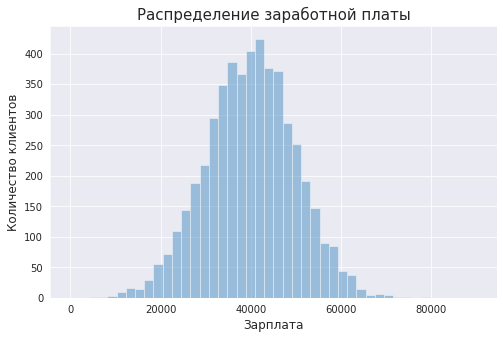

In [21]:
plt.figure(figsize=(8, 5))
sns.set_style("darkgrid")
fig = sns.distplot(insurance['salary'], kde = False, bins = np.linspace(start = 0, stop = 90000, num = 45))
fig.set_title("Распределение заработной платы", fontsize = 15)
fig.set_xlabel("Зарплата", fontsize = 12)
fig.set_ylabel("Количество клиентов", fontsize = 12)

plt.show()

Распределение зарплаты выглядит как нормальное.

Среднее значение признака **salary** почти одинаково для групп с выплатами и без:

In [22]:
pay_yes['salary'].mean().round(3)

39850.355

In [23]:
pay_no['salary'].mean().round(3)

39924.752

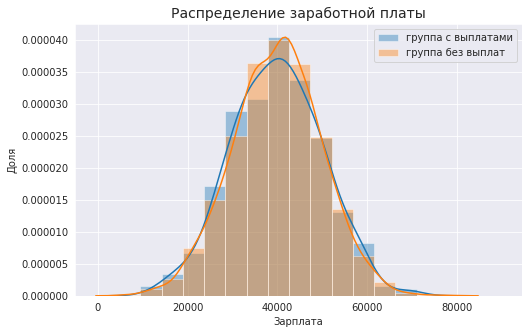

In [24]:
plt.figure(figsize=(8, 5))
fig1 = sns.distplot(pay_yes['salary'], kde = True, \
                    bins = np.linspace(start = 0, stop = 90000, num = 20), label = 'группа с выплатами') 
fig2 = sns.distplot(pay_no['salary'], kde = True, \
                    bins = np.linspace(start = 0, stop = 90000, num = 20), label = 'группа без выплат')  
fig2.set_title("Распределение заработной платы", fontsize = 14)
fig2.set_ylabel("Доля", fontsize = 10)
fig2.set_xlabel("Зарплата")
plt.legend()
plt.show()

Распределения выглядят практически идентично, существенной разницы между группами нет.

**n_family_members — количество членов семьи застрахованного**

In [25]:
insurance['n_family_members'].describe()

count    5000.000000
mean        1.194200
std         1.091387
min         0.000000
25%         0.000000
50%         1.000000
75%         2.000000
max         6.000000
Name: n_family_members, dtype: float64

Минимальное количество членов семьи застрахованного - 0 (вероятно, данные приведены без учета самого клиента), максимальное - 6, среднее - 1,2, медианное - 1. Стандартное отклонение - 1,09.

Построим график распределения:

In [26]:
n_fam = insurance.groupby(by = 'n_family_members').agg({'salary' : 'count'}).reset_index()\
                         .rename(columns = {'salary':'n'}).sort_values(by = 'n', ascending = False)

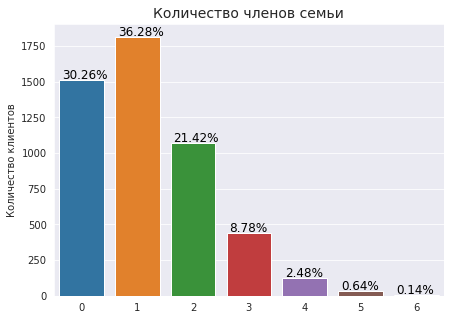

In [27]:
plt.figure(figsize=(7, 5))
fig = sns.barplot(x = "n_family_members", y = "n", data = n_fam) 
fig.set_title("Количество членов семьи", fontsize = 14)
fig.set_ylabel("Количество клиентов", fontsize = 10)
fig.set_xlabel("")
show_percent(fig, 0.05, 10)

30,26% клиентов не имеют семьи, у 36,28% один родственник, у 21,42% - двое, у 8,78% - трое. Доля остальных несущественна. 

Среднее значение признака **n_family_members** незначительно отличается в пользу группы без выплат:

In [28]:
pay_yes['n_family_members'].mean().round(3)

1.103

In [29]:
pay_no['n_family_members'].mean().round(3)

1.206

In [30]:
fam_py = pay_yes.groupby(by = 'n_family_members').agg({'salary' : 'count'}).reset_index()\
                         .rename(columns = {'salary':'n'})
fam_pn = pay_no.groupby(by = 'n_family_members').agg({'salary' : 'count'}).reset_index()\
                         .rename(columns = {'salary':'n'})

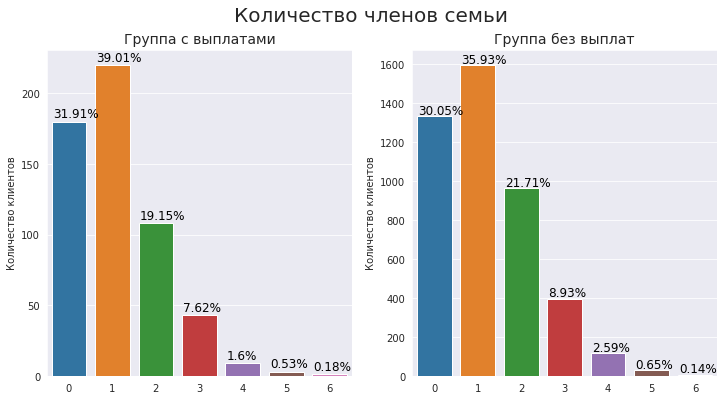

In [31]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

fig.suptitle('Количество членов семьи', fontsize = 20)

fig1 = sns.barplot(ax = axes[0], x = "n_family_members", y = "n", data = fam_py) 
fig1.set_title("Группа с выплатами", fontsize = 14)
fig1.set_ylabel("Количество клиентов", fontsize = 10)
fig1.set_xlabel("")
show_percent(fig1, 0.03, 3)

fig2 = sns.barplot(ax = axes[1], x = "n_family_members", y = "n", data = fam_pn) 
fig2.set_title("Группа без выплат", fontsize = 14)
fig2.set_ylabel("Количество клиентов", fontsize = 10)
fig2.set_xlabel("")
show_percent(fig2, 0.03, 10)

plt.show()

Существенной разницы между группами нет.

**Корреляция признаков**

Построим парные графики для признаков, чтобы предположить или опровергнуть их взаимную зависимость:

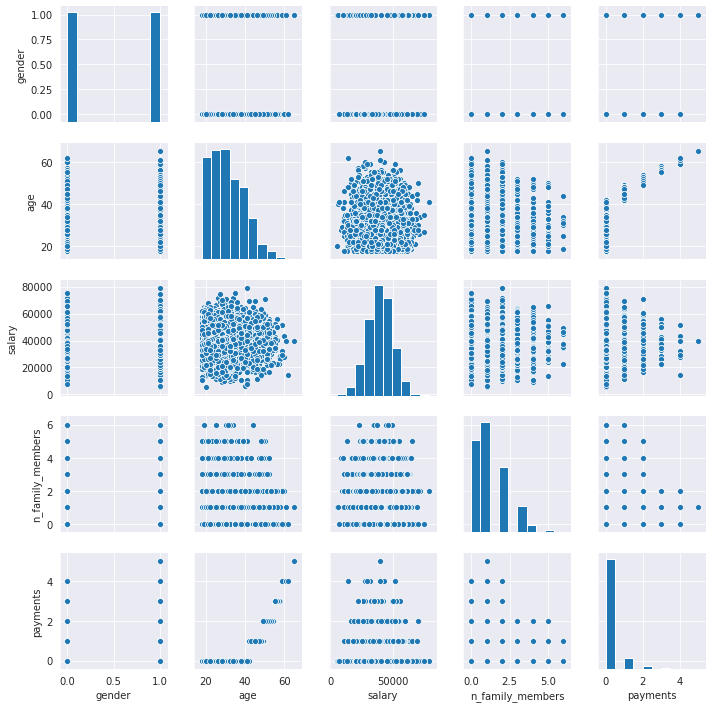

In [32]:
sns.pairplot(insurance, height = 2)
plt.show()

Очевидная зависимость наблюдается только у признаков **age** и **payments**, что мы уже выяснили выше. Явной взаимосвязи между нецелевыми признаками нет.

### Вывод

Данные подготовлены к дальнейшему анализу:
- переименованы столбцы;
- сделана проверка на дубликаты (найдено 153 экземпляра; удалений строк не было, поскольку нет переменной, позволяющей однозначно идентифицировать записи);
- пропущенные значения не обнаружены;
- проведен исследовательский анализ каждого признака в разрезе целевой переменной:
    - аномалий в данных не выявлено;
    - обнаружена существенная корреляция между целевой переменной и возрастом клиентов: страховые выплаты получают преимущественно люди от 43 до 62 лет, и только они;
    - корреляций между другими парами признаков не выявлено.

## Умножение матриц

Обозначения:

- $X$ — матрица признаков (нулевой столбец состоит из единиц)

- $y$ — вектор целевого признака

- $P$ — матрица, на которую умножаются признаки

- $w$ — вектор весов линейной регрессии (нулевой элемент равен сдвигу)

Предсказания:

$$
a = Xw
$$

Задача обучения:

$$
w = \arg\min_w MSE(Xw, y)
$$

Формула обучения:

$$
w = (X^T X)^{-1} X^T y
$$

**Ответ:** При умножении признаков на обратимую матрицу качество линейной регрессии не изменится. Покажем это, а также установим связь между параметрами в исходной и преобразованной задачах.

**Обоснование:** 
новая задача будет выглядеть следующим образом.

Преобразование:

$$
\hat a = XP\hat w
$$

Задача обучения:

$$
\hat w = \arg\min_\hat w MSE(XP\hat w, y)
$$

Формула обучения:

$$
\hat w = ((XP)^T XP)^{-1} (XP)^T y
$$

Воспользуемся свойствами обратных и транспонированных матриц:
$$
(AB)^T = B^TA^T
$$

$$
(AB)^{-1} = B^{-1}A^{-1}
$$

Поскольку $P$ обратима, то для $P^T$ тоже существует обратная матрица.

Преобразуем новый вектор параметров:

$$
\hat w = ((XP)^T XP)^{-1} (XP)^T y = (P^TX^TXP)^{-1}P^TX^Ty = P^{-1}(P^TX^TX)^{-1}P^TX^Ty = P^{-1}(X^TX)^{-1}(P^T)^{-1}P^TX^Ty =
$$

$$
= P^{-1}(X^TX)^{-1}X^Ty = P^{-1}w
$$

Тогда $\hat a = XP\hat w = XPP^{-1}w = Xw = a$

Следовательно, предсказания $\hat a$ для новой модели совпадают с предсказаниями $a$ для исходной, а параметры связаны формулой $\hat w = P^{-1}w$. 

## Алгоритм преобразования

**Алгоритм**

1. Умножить матрицу признаков $X_{mxn}$ на случайным образом сгенерированную обратимую матрицу $P_{nxn}$.
2. Обучить модель линейной регрессии на новой модели и получить вектор предсказаний.

**Обоснование**

Алгоритм решает поставленную задачу защиты персональных данных клиентов. После умножения на случайную матрицу восстановить информацию о признаках, не зная элементов этой матрицы, будет практически невозможно.

Как было показано выше, умножение матрицы признаков на случайную матрицу не изменит предсказаний модели, а следовательно, не ухудшит качество регрессии. Убедимся в этом на рассматриваемом датасете.

## Проверка алгоритма

Целевой признак в рассматриваемой задаче - это показатель количества страховых выплат:

In [33]:
target = insurance['payments']
features = insurance.drop('payments', axis = 1)

Масштабируем количественные признаки:

In [34]:
numeric = ['age', 'salary', 'n_family_members']

scaler = StandardScaler()
scaler.fit(features[numeric]) 

features[numeric] = scaler.transform(features[numeric])

Обучим исходную модель и оценим качество метрикой R2:

In [35]:
def lr(feat, targ):

    model_lr = LinearRegression() 
    model_lr.fit(feat, targ)
    predictions = model_lr.predict(feat)
    r2 = r2_score(targ, predictions).round(5)
    print("R2:", r2)

In [36]:
lr(features, target)

R2: 0.42495


Теперь проделаем те же операции для преобразованных данных. Сначала сгенерируем обратимую матрицу:

In [37]:
P = np.linalg.inv(np.random.randint(1000, size = (4, 4)))
P

array([[-0.00587283,  0.00049032, -0.00597233,  0.01029506],
       [ 0.00951415, -0.00066869,  0.00573091, -0.01115876],
       [ 0.00436532, -0.00096824,  0.00478717, -0.00637918],
       [-0.00662789,  0.00154856, -0.00298118,  0.00609662]])

Умножим на нее матрицу признаков:

In [38]:
features_new = features @ P

Рассчитаем R2 для преобразованной модели:

In [39]:
lr(features_new, target)

R2: 0.42495


Метрики получились одинаковыми для исходной и преобразованной модели, что подтверждает корректную работу предложенного алгоритма.

## Вывод

В работе решалась задача разработки такого метода преобразования данных о клиентах страховой компании, чтобы по ним было сложно восстановить персональную информацию.

В ходе предварительного анализа данные были подготовлены к дальнейшей работе:
- переименованы столбцы;
- сделана проверка на дубликаты;
- пропущенные значения не найдены;
- проведен исследовательский анализ признаков в разрезе целевой переменной:
    - аномалий в данных не выявлено;
    - обнаружена существенная корреляция между целевой переменной выплат и возрастом клиентов: страховые возмещения получают преимущественно люди от 43 до 62 лет, и только они.

Приведен алгоритм преобразования данных:

1. Умножить матрицу признаков $X_{mxn}$ на случайным образом сгенерированную обратимую матрицу $P_{nxn}$.
2. Обучить модель линейной регрессии на новой модели и получить вектор предсказаний. 

Математически обосновано свойство алгоритма сохранять качество предсказаний. Осуществлена проверка работы алгоритма на датасете клиентов страховой компании. Показано, что метрики R2 на исходных и преобразованных данных действительно совпадают.
